# 🥱 LangGraph_ State Memory篇

❤️ Created by [hengshiousheu](https://huggingface.co/Heng666).

# 環境建置

## 安裝套件包

在本演練中，

我們將使用以下套件：

In [ ]:
%pip install --upgrade --quiet langchain
%pip install --upgrade --quiet langchain-openai
%pip install --upgrade --quiet langgraph
%pip install --upgrade --quiet langchain-community

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 990.6/990.6 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 384.0/384.0 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.2/140.2 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.7/360.7 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.

我們需要設置 環境變數 OPENAI_API_KEY ，可以直接完成，如下所示：


In [ ]:
import os
import getpass
from google.colab import userdata

os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')

## 建立小型 Graph

In [ ]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator

Define a simple 2 node graph with the following state:
 - lnode: last node
 - scratch: a scratchpad location
 - count : a counter that is incremented each step

### 定義狀態

In [ ]:
class AgentState(TypedDict):
    lnode: str
    scratch: str
    count: Annotated[int, operator.add]

### 定義節點函數

In [ ]:
def node1(state: AgentState):
    print(f"node1, count:{state['count']}")
    return {"lnode": "node_1",
            "count": 1,
           }
def node2(state: AgentState):
    print(f"node2, count:{state['count']}")
    return {"lnode": "node_2",
            "count": 1,
           }

##### 設立條件邊

In [ ]:
def should_continue(state):
    return state["count"] < 3

### 編譯整張 Graph

圖論應用說明:
1. 節點 (Nodes): Node1 和 Node2 代表系統中的兩個狀態或處理步驟
2. 邊 (Edges): 連接節點的邊表示狀態轉移或處理流程
3. 有向圖 (Directed Graph): 邊是有方向的,表示狀態轉移的方向
4. 條件轉移: 使用條件邊實現了基於條件的狀態轉移
5. 循環 (Cycle): Node1 -> Node2 -> Node1 形成了一個潛在的循環
6. 終止狀態: END 代表流程的結束點

In [ ]:
from langgraph.checkpoint.memory import MemorySaver

# 初始化 StateGraph
builder = StateGraph(AgentState)

# 添加節點
builder.add_node("Node1", node1)
builder.add_node("Node2", node2)

# 添加邊
builder.add_edge("Node1", "Node2")
builder.add_conditional_edges(
    "Node2",
    should_continue,
     {True: "Node1", False: END}
  )
builder.set_entry_point("Node1")

# Set up memory
memory = MemorySaver()

graph = builder.compile(checkpointer=memory)

### 視覺化 GRaph

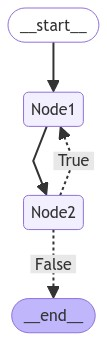

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

### 與 GRaph 互動

In [ ]:
thread = {
    "configurable": {
        "thread_id": "1"
        }
    }

graph.invoke({"count":0, "scratch":"hi"},thread)

node1, count:0
node2, count:1
node1, count:2
node2, count:3


{'lnode': 'node_2', 'scratch': 'hi', 'count': 4}

### 查看狀態(state)

Get the current state. Note the values which are the AgentState. Note the config and the thread_ts. You will be using those to refer to snapshots below.

In [ ]:
import rich

result = graph.get_state(thread)

rich.print(result)

StateSnapshot(
    values={'lnode': 'node_2', 'scratch': 'hi', 'count': 4},
    next=(),
    config={
        'configurable': {
            'thread_id': '1',
            'checkpoint_ns': '',
            'checkpoint_id': '1ef561dc-bcde-67c2-8004-03e814a1fc10'
        }
    },
    metadata={'source': 'loop', 'writes': {'Node2': {'lnode': 'node_2', 'count': 1}}, 'step': 4},
    created_at='2024-08-09T07:05:44.508382+00:00',
    parent_config={
        'configurable': {
            'thread_id': '1',
            'checkpoint_ns': '',
            'checkpoint_id': '1ef561dc-bccf-6fed-8003-870412c94ed8'
        }
    }
)

查看歷史狀態

> 有些文件是寫說 `thread_ts`, `parent_ts`，根據官方文件 [LangGraph v0.2](https://blog.langchain.dev/langgraph-v0-2/)，已經分別改名為 `checkpoint_id` 以及 `parent_checkpoint_id`

In [ ]:
for state in graph.get_state_history(thread):
    rich.print(state, "\n")

StateSnapshot(
    values={'lnode': 'node_2', 'scratch': 'hi', 'count': 4},
    next=(),
    config={
        'configurable': {
            'thread_id': '1',
            'checkpoint_ns': '',
            'checkpoint_id': '1ef561dc-bcde-67c2-8004-03e814a1fc10'
        }
    },
    metadata={'source': 'loop', 'writes': {'Node2': {'lnode': 'node_2', 'count': 1}}, 'step': 4},
    created_at='2024-08-09T07:05:44.508382+00:00',
    parent_config={
        'configurable': {
            'thread_id': '1',
            'checkpoint_ns': '',
            'checkpoint_id': '1ef561dc-bccf-6fed-8003-870412c94ed8'
        }
    }
)

StateSnapshot(
    values={'lnode': 'node_1', 'scratch': 'hi', 'count': 3},
    next=('Node2',),
    config={
        'configurable': {
            'thread_id': '1',
            'checkpoint_ns': '',
            'checkpoint_id': '1ef561dc-bccf-6fed-8003-870412c94ed8'
        }
    },
    metadata={'source': 'loop', 'writes': {'Node1': {'lnode': 'node_1', 'count': 1}}, 'step': 3},
    created_at='2024-08-09T07:05:44.502430+00:00',
    parent_config={
        'configurable': {
            'thread_id': '1',
            'checkpoint_ns': '',
            'checkpoint_id': '1ef561dc-bcc2-654d-8002-cee129f19add'
        }
    }
)

StateSnapshot(
    values={'lnode': 'node_2', 'scratch': 'hi', 'count': 2},
    next=('Node1',),
    config={
        'configurable': {
            'thread_id': '1',
            'checkpoint_ns': '',
            'checkpoint_id': '1ef561dc-bcc2-654d-8002-cee129f19add'
        }
    },
    metadata={'source': 'loop', 'writes': {'Node2': {'lnode': 'node_2', 'count': 1}}, 'step': 2},
    created_at='2024-08-09T07:05:44.496829+00:00',
    parent_config={
        'configurable': {
            'thread_id': '1',
            'checkpoint_ns': '',
            'checkpoint_id': '1ef561dc-bc9c-6d50-8001-e9bee1517c9b'
        }
    }
)

StateSnapshot(
    values={'lnode': 'node_1', 'scratch': 'hi', 'count': 1},
    next=('Node2',),
    config={
        'configurable': {
            'thread_id': '1',
            'checkpoint_ns': '',
            'checkpoint_id': '1ef561dc-bc9c-6d50-8001-e9bee1517c9b'
        }
    },
    metadata={'source': 'loop', 'writes': {'Node1': {'lnode': 'node_1', 'count': 1}}, 'step': 1},
    created_at='2024-08-09T07:05:44.481474+00:00',
    parent_config={
        'configurable': {
            'thread_id': '1',
            'checkpoint_ns': '',
            'checkpoint_id': '1ef561dc-bc87-6d50-8000-05126d1312e2'
        }
    }
)

StateSnapshot(
    values={'scratch': 'hi', 'count': 0},
    next=('Node1',),
    config={
        'configurable': {
            'thread_id': '1',
            'checkpoint_ns': '',
            'checkpoint_id': '1ef561dc-bc87-6d50-8000-05126d1312e2'
        }
    },
    metadata={'source': 'loop', 'writes': None, 'step': 0},
    created_at='2024-08-09T07:05:44.472892+00:00',
    parent_config={
        'configurable': {
            'thread_id': '1',
            'checkpoint_ns': '',
            'checkpoint_id': '1ef561dc-bc82-6bdb-bfff-cb96ef83cd2d'
        }
    }
)

StateSnapshot(
    values={'count': 0},
    next=('__start__',),
    config={
        'configurable': {
            'thread_id': '1',
            'checkpoint_ns': '',
            'checkpoint_id': '1ef561dc-bc82-6bdb-bfff-cb96ef83cd2d'
        }
    },
    metadata={'source': 'input', 'writes': {'count': 0, 'scratch': 'hi'}, 'step': -1},
    created_at='2024-08-09T07:05:44.470804+00:00',
    parent_config=None
)

保存歷史資訊成 list 後續方便

In [ ]:
states = []
for state in graph.get_state_history(thread):
    states.append(state.config)
    print(f"{state.config}, count: {state.values['count']}")

{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef561e0-cb40-6be9-8004-f21497772532'}}, count: 4
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef561e0-cb33-6d1b-8003-d7c00eb02a41'}}, count: 3
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef561e0-cb25-662d-8002-463f51af9a58'}}, count: 2
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef561dc-bcde-67c2-8004-03e814a1fc10'}}, count: 4
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef561dc-bccf-6fed-8003-870412c94ed8'}}, count: 3
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef561dc-bcc2-654d-8002-cee129f19add'}}, count: 2
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef561dc-bc9c-6d50-8001-e9bee1517c9b'}}, count: 1
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef561dc-bc87-6d50-8000-05126d1312e2'}}, count: 0


取得特定狀態資訊

In [ ]:
specific_state = graph.get_state(states[-3])
rich.print(specific_state)

StateSnapshot(
    values={'lnode': 'node_1', 'scratch': 'hi', 'count': 1},
    next=('Node2',),
    config={
        'configurable': {
            'thread_id': '1',
            'checkpoint_ns': '',
            'checkpoint_id': '1ef561dc-bc9c-6d50-8001-e9bee1517c9b'
        }
    },
    metadata={'source': 'loop', 'writes': {'Node1': {'lnode': 'node_1', 'count': 1}}, 'step': 1},
    created_at='2024-08-09T07:05:44.481474+00:00',
    parent_config={
        'configurable': {
            'thread_id': '1',
            'checkpoint_ns': '',
            'checkpoint_id': '1ef561dc-bc87-6d50-8000-05126d1312e2'
        }
    }
)

將該狀態用於`invoke` 中以回到過去。

請注意，它使用 `states[-3]` 作為 `current_state` 並繼續到 `node2`。

In [ ]:
graph.invoke(None, states[-3])

node1, count:2
node2, count:3


{'lnode': 'node_2', 'scratch': 'hi', 'count': 4}